# Transfer learning(InceptionV3) on Horse vs Humans 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import tensorflow as tf
import os

In [2]:
from tensorflow.keras import Model
from tensorflow.keras import layers

In [3]:
from tensorflow.keras.applications import InceptionV3

path_inception = '../inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(path_inception)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()
    
    

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Shape of the last layer : ',last_layer.output_shape)
last_output = last_layer.output

Shape of the last layer :  (None, 7, 7, 768)


In [5]:
# Implementing Callbacks

class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy') > 0.97):
            print('\n \nStopping the training !!! Accuracy Reached 97% \n \n')
            self.model.stop_training = True
        
        

In [6]:
# Defining the model 
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x) # Discard the fraction of neurons
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)

model.compile(optimizer=RMSprop(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
# Getting the Data Directories

base_dir = '../horse-or-human/'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')


In [8]:
len(os.listdir(train_dir+'/horses'))

500

In [9]:
len(os.listdir(train_dir+'/humans'))

527

In [10]:
# Image Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   width_shift_range=0.0,
                                   height_shift_range=0.0,
                                   shear_range=0.0,
                                   zoom_range=0.0,
                                   rotation_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest'
                                  )
test_datagen = ImageDataGenerator(rescale=1./255.0)

train_generator = train_datagen.flow_from_directory(train_dir,
                                 batch_size=20,
                                 target_size=(150,150),
                                 class_mode='binary')
                                 
test_generator = test_datagen.flow_from_directory(validation_dir,
                                 batch_size=20,
                                 target_size=(150,150),
                                 class_mode='binary')
                                 



Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [11]:
callback1 = my_callback()
hist = model.fit_generator(train_generator,
                           epochs = 30,
                           validation_data = test_generator,
                           callbacks = [callback1]
                          )


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 13 steps
Epoch 1/30
52/52 [==============================] - 15s 281ms/step - loss: 0.1519 - accuracy: 0.9338 - val_loss: 0.0246 - val_accuracy: 0.9922
Epoch 2/30
51/52 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.9930
 
Stopping the training !!! Accuracy Reached 97% 
 

52/52 [==============================] - 5s 96ms/step - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0353 - val_accuracy: 0.9922


# Plotting the Accuracy and Loss

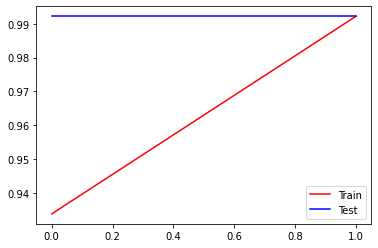

In [14]:
plt.plot(hist.history['accuracy'],'r')
plt.plot(hist.history['val_accuracy'],'b')
plt.legend(['Train','Test'],loc='best')


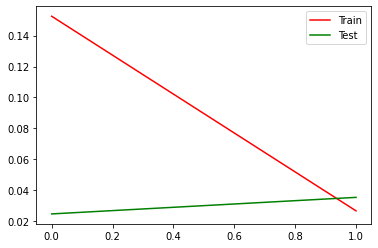

In [13]:
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'g')
plt.legend(['Train','Test'],loc='best')